In [1]:
# importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# 1. Data Exploration

In the first section of this notebook we will look at two datasets: one containing half-hourly weather readings in Edinburgh, and the other listing sales at Edinburgh's Bread Basket Café.

## 1.1 Edinburgh weather


In [2]:
# importing the weather dataset
weather_df = pd.read_csv("../input/edinburgh-weather/edinburgh-wx.csv", parse_dates=[["Date", "Time"]])

# dropping two columns containing the same value throughout
weather_df = weather_df.drop(columns=["Precip.", "Precip Accum"])

# converting Farenheit to Celsius
weather_df["Temperature"] = weather_df["Temperature"].apply(lambda x: int((x-32)*5/9))

weather_df

,Date_Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition
0,2016-10-30 00:20:00,11,48,88,SW,7,0,30.3,Cloudy
1,2016-10-30 00:50:00,11,48,88,WSW,6,0,30.3,Cloudy
2,2016-10-30 01:20:00,11,48,88,W,7,0,30.2,Cloudy
3,2016-10-30 01:50:00,11,48,88,W,6,0,30.2,Cloudy
4,2016-10-30 01:20:00,10,48,94,WSW,5,0,30.2,Cloudy
...,...,...,...,...,...,...,...,...,...
7759,2017-04-09 21:50:00,6,37,81,WSW,12,0,29.9,Fair
7760,2017-04-09 22:20:00,6,37,81,WSW,12,0,29.9,Fair
7761,2017-04-09 22:50:00,6,37,81,WSW,13,0,29.9,Fair
7762,2017-04-09 23:20:00,5,37,87,WSW,10,0,29.9,Fair


We can see that the weather dataset consists of 7764 records of Edinburgh weather, from 30 October 2016 to 9 April 2017. The weather has been recorded every 30 minutes, at 20 and 50 minutes past every hour.

Most of the features are numeric, apart from wind direction and condition, that are nominal.

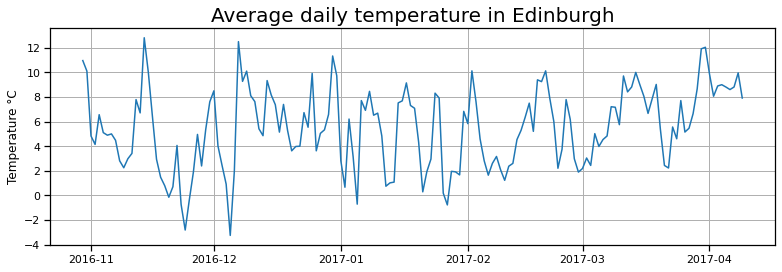

In [3]:
weather_by_day = weather_df.copy()

# creating a date column
weather_by_day["Date"] = weather_by_day["Date_Time"].dt.date

# grouping the data, recording the average daily temperature
weather_by_day = weather_by_day.groupby(["Date"]).mean().reset_index()

# plotting the data
sns.set_context("notebook")
plt.figure(figsize=(13, 4))
ax = plt.subplot()
plt.plot(weather_by_day["Date"], weather_by_day["Temperature"])
ax.set_ylabel("Temperature °C")
plt.title('Average daily temperature in Edinburgh', fontsize=20)
ax.grid()
plt.show()

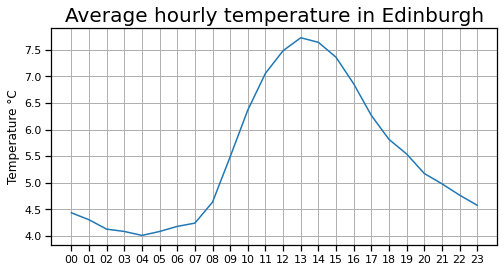

In [4]:
weather_by_hour = weather_df.copy()

# creating a time column
weather_by_hour["Time"] = pd.to_datetime(weather_by_hour["Date_Time"]).dt.time.apply(lambda x: x.strftime("%H"))

# grouping the data, recording the average hourly temperature
weather_by_hour = weather_by_hour.groupby(["Time"]).mean().reset_index()

# plotting the data
plt.figure(figsize=(8, 4))
ax = plt.subplot()
plt.plot(weather_by_hour["Time"], weather_by_hour["Temperature"])
ax.set_ylabel("Temperature °C")
plt.title('Average hourly temperature in Edinburgh', fontsize=20)
ax.grid()
plt.show()

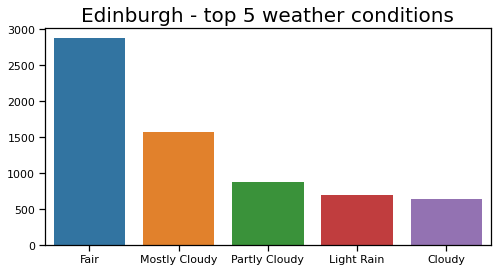

In [5]:
conditions = pd.DataFrame([weather_df["Condition"].value_counts().head()])

plt.figure(figsize=(8, 4))
sns.barplot(data=conditions)
plt.title('Edinburgh - top 5 weather conditions', fontsize=20)
plt.show()

## 1.2 Bread Basket Dataset

In [6]:
# importing the Bread Basket dataset
breadbasket_df = pd.read_csv("../input/bakery-data/BreadBasket.csv", parse_dates=[['Date', 'Time']])

# dropping rows where the transaction is NONE
breadbasket_df = breadbasket_df[breadbasket_df["Item"] != "NONE"]

breadbasket_df.head()

,Date_Time,Transaction,Item
0,2016-10-30 09:58:11,1,Bread
1,2016-10-30 10:05:34,2,Scandinavian
2,2016-10-30 10:05:34,2,Scandinavian
3,2016-10-30 10:07:57,3,Hot chocolate
4,2016-10-30 10:07:57,3,Jam


Looking at the Bread Basket dataset, we can see that it logs the time of the transaction and the names of the items sold. Furthermore, by looking at the Transaction column, we can see which items were sold together.

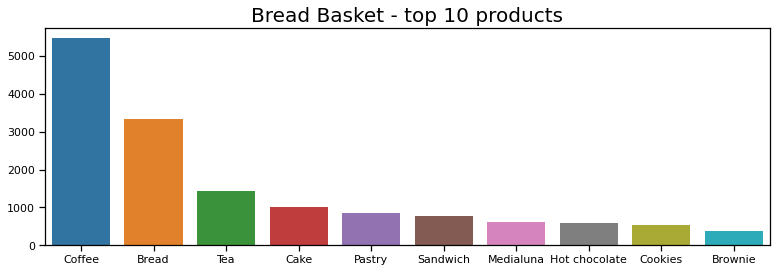

In [7]:
top_10_prods = pd.DataFrame([breadbasket_df["Item"].value_counts().head(10)])

plt.figure(figsize=(13, 4))
sns.barplot(data=top_10_prods)
plt.title('Bread Basket - top 10 products', fontsize=20)
plt.show()

In this notebook we will try to predict the sales in the café according to the weather conditions at the time, and according to the day and time of the transaction. Thus, in this study we will not use information about whether the goods sold were part of one or more transactions, and so we will discard the "transaction" column.

Given that the weather dataset captures the weather at 20 and 50 minutes after each hour, we will round down the sales time to 20 minutes after each hour, which will make it easier to combine the datasets in subsequent steps. 

Instead of looking at sales of specific products, we will look at sales of all items as well as sales of hot drinks (coffee, tea and hot chocolate), as these sales are potentially the ones that are most affected by cold weather.

In the next steps, we will also look at the seasonality of the data, in particular the daily and weekly sales patterns.  


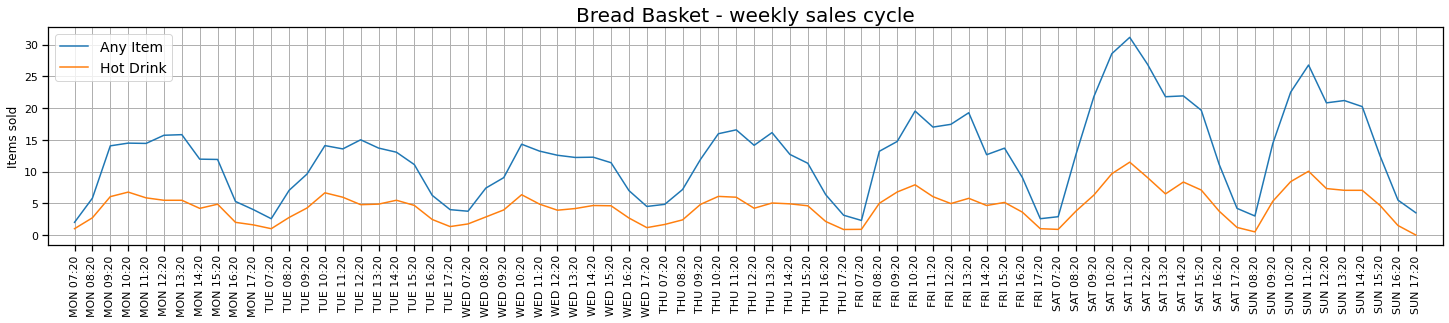

In [8]:
# we are not going to use the information about whether the sold items were a part of one or multiple transactions
breadbasket_df = breadbasket_df.drop(columns=["Transaction"])

# function to round down time to 20 mins past every hour (the same as the weather dataset)
def convert_time(datetime):
  if datetime.minute < 20:
    datetime = datetime.replace(hour=(datetime.hour-1))
  datetime = datetime.replace(minute=20, second=0)
  return datetime

# appying the above function
breadbasket_df["Date_Time"] = breadbasket_df["Date_Time"].apply(convert_time)

# creating a new column for hot drinks
breadbasket_df["Hot Drink"] = breadbasket_df["Item"].apply(lambda x: "Yes" if x in ["Tea", "Coffee", "Hot chocolate"] else None)

# creating a new dataframe containing number of all items sold and hot drinks sold in each time interval
sold_items_df = breadbasket_df.groupby(["Date_Time"]).count().reset_index()

# adding a day of the week column
sold_items_df["Weekday_id"] = sold_items_df["Date_Time"].dt.dayofweek
days = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
sold_items_df["Weekday"] = sold_items_df["Weekday_id"].apply(lambda x: days[x])

# creating a new column containing time only, and formatting it to hide seconds
sold_items_df["Time"] = pd.to_datetime(sold_items_df["Date_Time"]).dt.time.apply(lambda x: x.strftime("%H:%M"))
sold_items_df["Weekday_Time"] = sold_items_df["Weekday"] + " " + pd.to_datetime(sold_items_df["Date_Time"]).dt.time.apply(lambda x: x.strftime("%H:%M"))

# the sales before 7am and after 6pm are rare, and so we are dropping them from the dataset
sold_items_df = sold_items_df[(sold_items_df["Date_Time"].dt.hour >= 7) & (sold_items_df["Date_Time"].dt.hour < 18)]

# creating a copy of the dataframe
sold_items_weekly_cycle = sold_items_df.copy()

# adding up the items sold in each 1-hour slot on all the given days
sold_items_weekly_cycle = sold_items_weekly_cycle.groupby(["Weekday_id", "Weekday", "Time", "Weekday_Time"]).mean().reset_index()

# plotting the data
plt.figure(figsize=(25, 4))
ax = plt.subplot()
plt.plot(sold_items_weekly_cycle.index, sold_items_weekly_cycle["Item"])
plt.plot(sold_items_weekly_cycle.index, sold_items_weekly_cycle["Hot Drink"])
legend_labels = ["Any Item", "Hot Drink"]
plt.legend(legend_labels, loc=2, fontsize=14)
ax.set_xticks(sold_items_weekly_cycle.index)
ax.set_xticklabels(sold_items_weekly_cycle["Weekday_Time"], rotation=90)
plt.title('Bread Basket - weekly sales cycle', fontsize=20)
ax.set_ylabel("Items sold")
ax.grid()
plt.margins(0.02, 0.05)
plt.show()

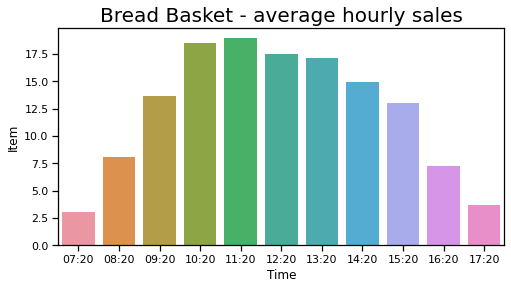

In [9]:
hourly_sales = sold_items_weekly_cycle.groupby(["Time"]).mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x="Time", y="Item", data=hourly_sales)
plt.title('Bread Basket - average hourly sales', fontsize=20)
plt.show()

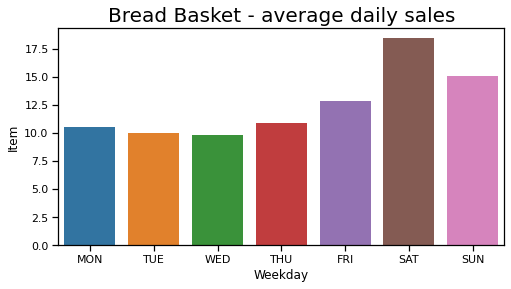

In [10]:
weekly_sales = sold_items_weekly_cycle.groupby(["Weekday"]).mean().reset_index()

plt.figure(figsize=(8, 4))
ax = plt.subplot()
sns.barplot(x="Weekday_id", y="Item", data=weekly_sales)
plt.title('Bread Basket - average daily sales', fontsize=20)
ax.set_xticklabels(days)
ax.set_xlabel("Weekday")
plt.show()

# 2. Exploring the effect of weather on sales

We can see in the above graphs that both daily temperature and café sales have clear daily patterns, with temperature and café sales peaking at 1pm and 11am respectively. However, given that we know that café sales can be attributed to conventional working hours, and customary times for coffee breaks, it would be incorrect to deduce a cause-and-effect relationship from any correlation between the temperature and the sales.

Therefore, instead of attempting to predict the number of sales with the weather data, we will attempt to predict the difference from number of sales that can be expected in a particular hour of a particular weekday. We will take the following steps:


*   Calculate the average sales at every hour on every day of the week (e.g. Mondays at 10am, Fridays at 1pm, etc.)

*   Calculate the difference from this average for every hour in the given data (e.g. if we usually sell 23 items at 10am on a Sunday, and this Sunday we have sold 50 items, we have the difference of +27)

*   Attempt to predict this sales difference with the weather data








In [11]:
sales_diffs = sold_items_df.copy()

# a function for calculating the differences in the sales of all items
def calc_diffs_item(row):
  return row["Item"] - (sold_items_weekly_cycle.loc[(sold_items_weekly_cycle["Time"] == row["Time"]) & (sold_items_weekly_cycle["Weekday_id"] == row["Weekday_id"]), "Item"]).item()

# a function for calculating the differences in the sales of hot drinks
def calc_diffs_drink(row):
  return row["Hot Drink"] - (sold_items_weekly_cycle.loc[(sold_items_weekly_cycle["Time"] == row["Time"]) & (sold_items_weekly_cycle["Weekday_id"] == row["Weekday_id"]), "Hot Drink"]).item()

# applying the functions
sales_diffs["Item difference"] = sales_diffs.apply(calc_diffs_item, axis=1) # create a new column with a better name
sales_diffs["Hot Drink difference"] = sales_diffs.apply(calc_diffs_drink, axis=1) # create a new column with a better name

# dropping the superfluous columns
sales_diffs = sales_diffs.drop(columns=["Weekday_id", "Time", "Weekday", "Weekday_Time"])

sales_diffs.head()


,Date_Time,Item,Hot Drink,Item difference,Hot Drink difference
0,2016-10-30 09:20:00,17,4,2.590909,-1.318182
1,2016-10-30 10:20:00,50,8,27.500000,-0.409091
2,2016-10-30 11:20:00,33,12,6.227273,1.954545
3,2016-10-30 12:20:00,25,11,4.181818,3.681818
4,2016-10-30 13:20:00,28,8,6.818182,0.954545


Given that wind direction and weather condition, that are nominal values, we will need to convert them into numeric values using One-Hote Encoder.

In [12]:
# creating a separate dataframe with categorical values
wind_condition_onehot = weather_df[["Wind", "Condition"]]

# one-hot encoding the categorical values
wind_condition_onehot = pd.DataFrame(OneHotEncoder().fit_transform(wind_condition_onehot).toarray())

# dropping the categorical columns from the weather dataset
weather_onehot = weather_df.drop(columns=["Wind", "Condition"])

# creating a fully numerical weather dataset
weather_onehot = pd.concat([weather_onehot, wind_condition_onehot], axis=1)

# merging the weather and sales datasets
weather_and_sales = weather_onehot.merge(sales_diffs, on="Date_Time")

# dropping the datetime column
weather_and_sales = weather_and_sales.drop(columns=["Date_Time"])

# creating separate datasets for predicting the sales of hot drinks and all items
weather_and_sales_drink = weather_and_sales.drop(columns=["Item", "Hot Drink", "Item difference"])
weather_and_sales_item = weather_and_sales.drop(columns=["Item", "Hot Drink", "Hot Drink difference"])

We will start by predicting the sales difference for all items. We will split our data into a training set and a test set, assigning 30% of our data as our test set.

In [13]:
y = weather_and_sales_item["Item difference"].values
X = weather_and_sales_item.drop(columns=["Item difference"]).values

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state = 0) # 70% training and 30% test

We will attempt to predict the sales difference using Linear Regression and Random Forest regression methods. We will evaluate the model using the $R^2$ score, which represents the proportion of the variance for our y (Item difference) that's explained by the weather data.

In [14]:
linear = LinearRegression()

# fitting the model on the training data
linear.fit(train_X, train_y)

# predicting the response for test dataset
y_preds = linear.predict(val_X)

# evaluating the model
print("Linear Regression, R-Squared:", round(metrics.r2_score(val_y, y_preds), 4))

rfc = RandomForestRegressor(random_state=0, max_depth=5)

# fitting the model on the training data
rfc.fit(train_X, train_y)

# predicting the response for test dataset
y_preds = rfc.predict(val_X)

# evaluating the model
print("Random Forest Regressor, R-Squared:", round(metrics.r2_score(val_y, y_preds), 4))

Linear Regression, R-Squared: -0.0454
Random Forest Regressor, R-Squared: 0.0087


We can see that the $R^2$ score for both regression models is close to zero, which means that neither model can attribute the variance in sales to the weather conditions.

Attempting to predict hot drink sales yields similar results:

In [15]:
y = weather_and_sales_drink["Hot Drink difference"].values
X = weather_and_sales_drink.drop(columns=["Hot Drink difference"]).values

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state = 0) # 70% training and 30% test

# fitting the model on the training data
linear.fit(train_X, train_y)

# predicting the response for test dataset
y_preds = linear.predict(val_X)

# evaluating the model
print("Linear Regression, R-Squared:", round(metrics.r2_score(val_y, y_preds), 4))

# fitting the model on the training data
rfc.fit(train_X, train_y)

# predicting the response for test dataset
y_preds = rfc.predict(val_X)

# evaluating the model
print("Random Forest Regressor, R-Squared:", round(metrics.r2_score(val_y, y_preds), 4))

Linear Regression, R-Squared: -0.0314
Random Forest Regressor, R-Squared: -0.0111


Indeed, if we plot the differences in sales against the temperature and draw a line of best fit, we can see that there appears to be no correlation between these two values.

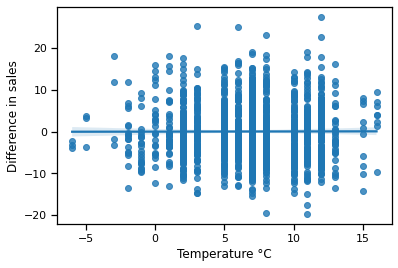

In [16]:
ax = plt.subplot()
sns.regplot(x="Temperature", y="Item difference", data=weather_and_sales_item)
ax.set_xlabel("Temperature °C")
ax.set_ylabel("Difference in sales")
plt.show()

#3. Predicting sales with TensorFlow

In this section we will attempt to predict cafe sales using TensorFlow. We will use the data we prepared earlier, containing hourly sales from 7am to 6pm. This data is in the form of a univariate time series – with only one variable (cafe sales) varying over time.

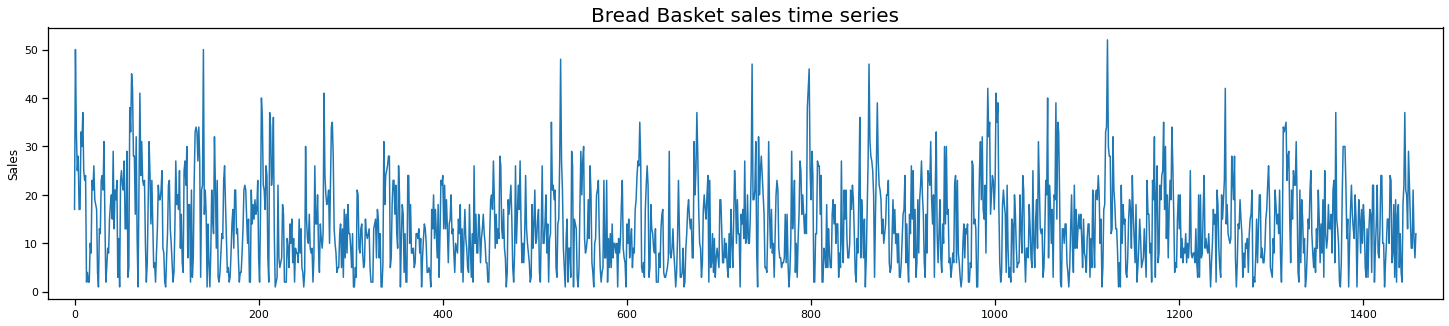

In [17]:
series = np.array(sold_items_df["Item"])
time = np.array(list(range(len(series))))
plt.figure(figsize=(25, 5))
plt.plot(time, series)
plt.title('Bread Basket sales time series', fontsize=20)
plt.ylabel("Sales")
plt.margins(0.02, 0.05)
plt.show()

First, we need to split our data into training and validation data. We will use the first 1000 hours as training data and the rest as validation data.

In [18]:
# we will use the first 1000 hours as training data, and the rest as validation data
split_time = 1000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:] 

As this is a time series problem, it relies on past data to determine future values. This approach is called the sliding window method. In our implementation of this approach, we will use 65 hourly sales values to predict sales for the 66th hour.

In [19]:
# window size is 65 as this is the approximate number of hours in a recorded week
window_size = 65
batch_size = 64
shuffle_buffer_size = 2000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Our TensorFlow model will consist of several layers, which are mathematical functions that allow us to extract features from the data:

*   Convolution layer – applies filters to data, highlighting different features.
*   2x Long short-term memory (LSTM) layers – process sequences of data, storing information about its long-term context.
*   3x Dense layers - deeply connected neural network layers.
*   Lambda layer – scales the output, making it comparable to time series values.


In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

# our TensorFlow model will consist of a convolution layer, followed by two long short-term memory (LSTM) layers, and finally dense layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200)

2022-02-15 22:56:39.018010: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-15 22:56:39.836024: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
15/15 [==============================] - 7s 126ms/step - loss: 13.8424 - mae: 14.3352
Epoch 2/200
15/15 [==============================] - 2s 125ms/step - loss: 6.8418 - mae: 7.3269
Epoch 3/200
15/15 [==============================] - 2s 129ms/step - loss: 6.6574 - mae: 7.1441
Epoch 4/200
15/15 [==============================] - 2s 124ms/step - loss: 6.5529 - mae: 7.0378
Epoch 5/200
15/15 [==============================] - 2s 120ms/step - loss: 6.5022 - mae: 6.9862
Epoch 6/200
15/15 [==============================] - 2s 120ms/step - loss: 6.4809 - mae: 6.9665
Epoch 7/200
15/15 [==============================] - 2s 119ms/step - loss: 6.4682 - mae: 6.9538
Epoch 8/200
15/15 [==============================] - 2s 119ms/step - loss: 6.4553 - mae: 6.9406
Epoch 9/200
15/15 [==============================] - 3s 163ms/step - loss: 6.4424 - mae: 6.9279
Epoch 10/200
15/15 [==============================] - 2s 122ms/step - loss: 6.4292 - mae: 6.9145
Epoch 11/200
15/15 [=================

The graph below shows that the Mean Absolute Error and Loss measures are steadily decreasing during the training.

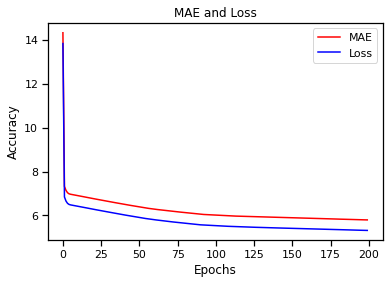

In [21]:
# Plotting Mean Absolute Error and Loss
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.show()

Finally, if we plot predicted sales against actual sales, we will see that both lines are similar. Although the extreme highs and lows were not predicted, the overall shape of the forecasts closely follows that of actual sales. 

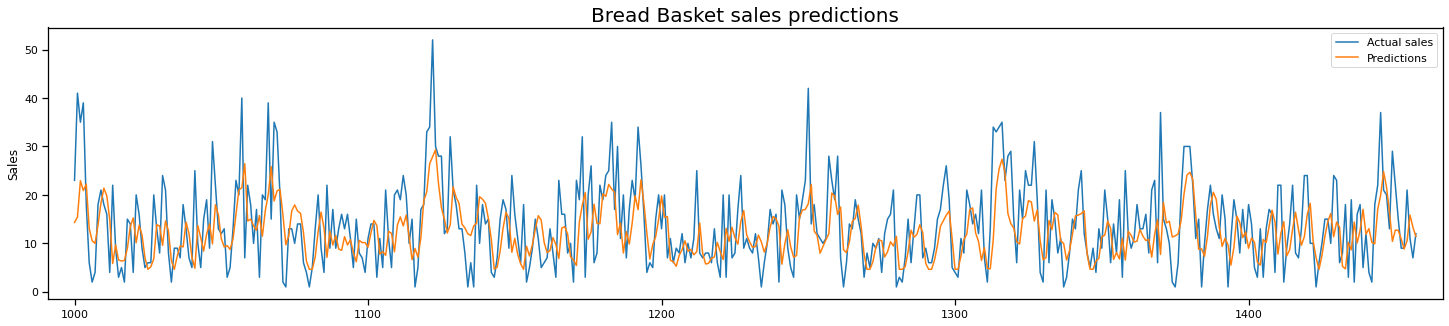

Mean Absolute Error: 6.0274


In [22]:
# forecasting sales
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# plotting predicted sales against the actual sales
plt.figure(figsize=(25, 5))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.margins(0.02, 0.05)
plt.title('Bread Basket sales predictions', fontsize=20)
plt.ylabel("Sales")
plt.legend(["Actual sales", "Predictions"])
plt.show()

# evaluating the model
print("Mean Absolute Error:", round(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy(), 4))